# Tutorial : Gradient boosting and random forest


In [1]:
# packages used in this tutorial 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# keras is only to get boston housing data
# boston housing is also here: from sklearn.datasets import load_boston
#import tensorflow as tf
from tensorflow import keras

# gradient boosting 
from xgboost import XGBRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# evaluation metrics
from sklearn.metrics import mean_squared_error

/Users/pierregentine/opt/anaconda3/envs/keras/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 0. Cursory look at the data

Let's split the data into a training and testing set. At training time, we will hold a portion of the data for validation purposes. The model weights will be updated using the training data. During training the model will never see the test data. This will be used once the model is fully trained to evaluate how well the model performs on data it has never seen before

The dataset contains 13 different features:
1. Per capita crime rate.
2. The proportion of residential land zoned for lots over 25,000 square feet.
3. The proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. The average number of rooms per dwelling.
7. The proportion of owner-occupied units built before 1940.
8. Weighted distances to five Boston employment centers.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (M - 0.63) ** 2 where M is the proportion of minority by town.
13. Percentage lower status of the population.

Each one of these input data features is stored using a different scale. Some features are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on. This is often the case with real-world data, and understanding how to explore and clean such data is an important skill to develop.

**Key Point:** As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. Is a feature relevant to the problem you want to solve or will it introduce bias? For more information, read about [ML fairness](https://developers.google.com/machine-learning/fairness-overview/).

In [2]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

57026/57026 [==============================] - 0s 0us/step
Training set: (404, 13)
Testing set:  (102, 13)


In [3]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.06588,0.0,2.46,0.0,0.488,7.765,83.3,2.7410,3.0,193.0,17.8,395.56,7.56
1,0.09512,0.0,12.83,0.0,0.437,6.286,45.0,4.5026,5.0,398.0,18.7,383.23,8.94
2,2.31390,0.0,19.58,0.0,0.605,5.880,97.3,2.3887,5.0,403.0,14.7,348.13,12.03
3,9.91655,0.0,18.10,0.0,0.693,5.852,77.8,1.5004,24.0,666.0,20.2,338.16,29.97
4,24.80170,0.0,18.10,0.0,0.693,5.349,96.0,1.7028,24.0,666.0,20.2,396.90,19.77


## Labels

This is what we are trying to predict. 

In [4]:
print(train_labels[0:10])  # Display first 10 entries

[39.8 21.4 19.1  6.3  8.3 20.4 33.4  8.5 13.1 22.8]


# 1. Build the model

The building block of both gradient boosting and random forest is a decision tree using the CART algorithm. This is not senstive to the input data and therefore it is not necessary to scale the data like we do for neural networks

## 1.1 define the model

In [13]:
#======================================================
# setup model parameters, choose RFR or XGB
# if you comment out a parameter it will use default value
#======================================================
# RFR parameters (random forest regression)
params_rfr = {'n_estimators':1000,
              'criterion':'mse', 
              #'ccp_alpha':0.001,
              'max_depth': 10,
              #'min_samples_leaf':1,
              #'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}


# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror',
              #'base_score': 0.5,     # chosen as median of validation set
              'n_estimators': 2000,  # number of trees to use
              'learning_rate': 0.01, 
              'max_depth': 30,       # how many levels are in each tree
              #'subsample': 1,
              #'colsample_bytree': 0.8,
              # REGULARIZATION  alpha (L2) and lambda (L1)
              'reg_alpha': 1,
              'reg_lambda': 0,}

In [14]:
#======================================================
# define the model, uncomment the one you want to use
#======================================================
model = RandomForestRegressor(**params_rfr)
#model = XGBRegressor(**params_xgb)

## 1.2 train the model

In [15]:
%%time
model.fit(train_data, train_labels)


/Users/pierregentine/opt/anaconda3/envs/keras/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


CPU times: user 1.75 s, sys: 62.8 ms, total: 1.82 s
Wall time: 1.83 s


RandomForestRegressor(criterion='mse', max_depth=10, max_features=None,
                      n_estimators=1000)

# 2. Predict (using test data)

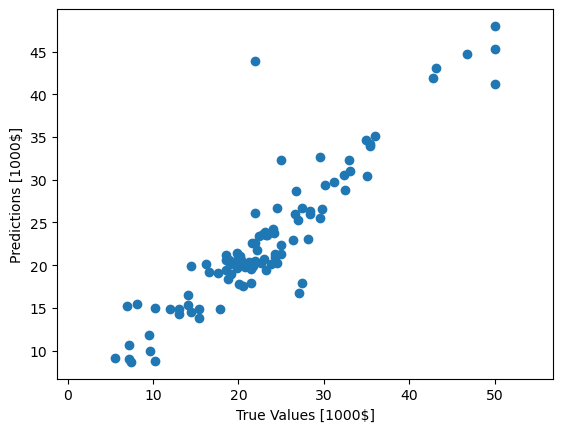

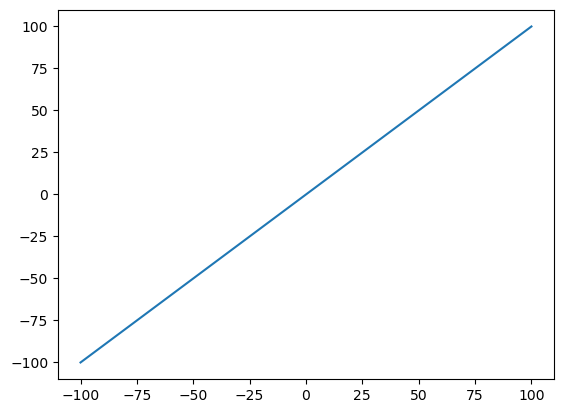

In [16]:
test_predictions = model.predict(test_data)

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()
_ = plt.plot([-100, 100], [-100, 100])

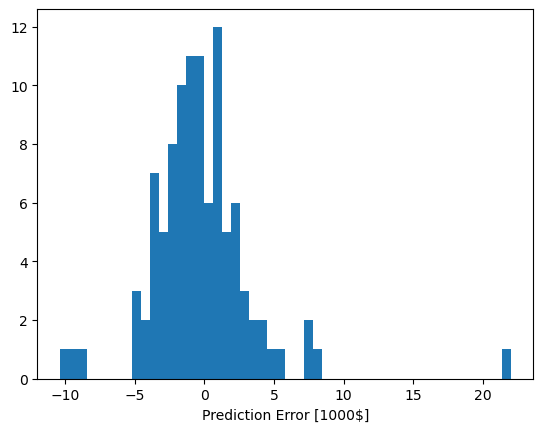

In [17]:
# histogram
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
plt.show()

## 3. RMSE

In [18]:
mse = mean_squared_error(test_labels, test_predictions)
print(f'the mse is {mse}')

the mse is 14.106766940898128


## 4. Feature importance

In [19]:
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

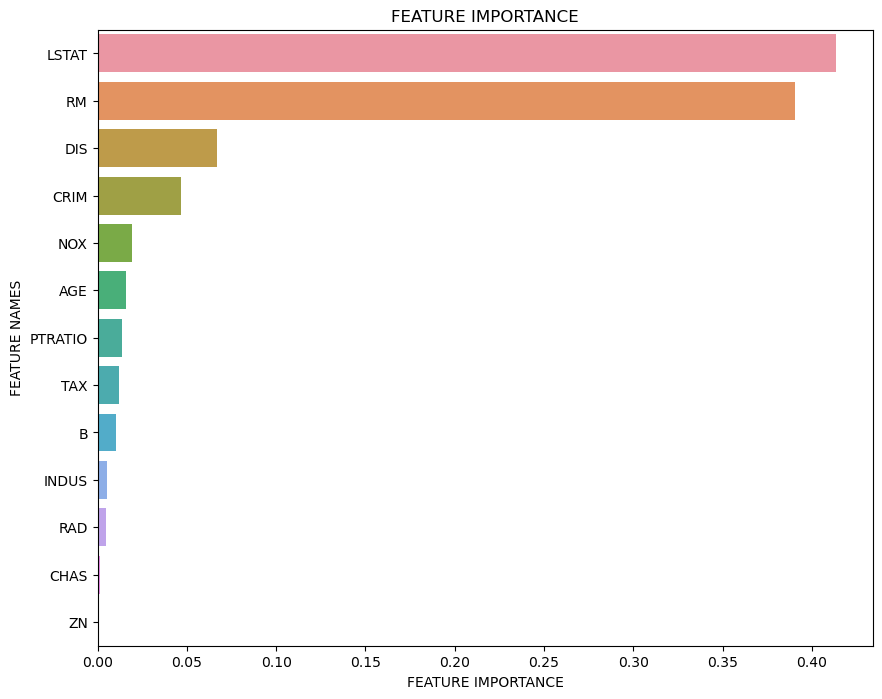

In [20]:
plot_feature_importance(model.feature_importances_, df.columns)